# Transfer learning with pretrained Keras models

Although Kernel resources were increased recently we still can not train useful CNNs without GPU. The original ImageNet set has quite a few different dog classes so we can reuse CNNs with pretrained ImageNet weights. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
start = dt.datetime.now()
print(start)

# Use Keras Pretrained Models dataset

Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details [here](https://www.kaggle.com/gaborfodor/keras-pretrained-models).

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.


In [ ]:
!ls ../input/keras-pretrained-models/

In [ ]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [ ]:
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

In [ ]:
!ls ~/.keras/models

In [ ]:
!ls ../input/dog-breed-identification

# Use top 16 classes
Using all the images would take more than the 1 hour kernel limit. Let's focus on the most frequent 16 breeds.

In [2]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
data_dir = ''
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [3]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
#labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [4]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

# ResNet50 class predictions for example images

In [5]:
print(labels.head(16))

                                   id                 breed  target
8    003df8b8a8b05244b1d920bb6cf451f9               basenji       1
9    0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound       1
12   00693b8bc2470375cc744a6391d397ec           maltese_dog       1
29   00bee065dcec471f26394855c5c2f3de                 cairn       1
48   013f8fdf6d638c7bb042f5f17e8a9fdc       tibetan_terrier       1
57   0162b3e0144fb1d1ab82fbff3ace9938              shih-tzu       1
70   01b36cb1b80ab8c3a7d2b7128ad21bdc               samoyed       1
79   01e787576c003930f96c966f9c3e1d44    scottish_deerhound       1
80   01ee3c7ff9bcaba9874183135877670e           entlebucher       1
88   021b5a49189665c0442c19b5b33e8cf1           entlebucher       1
90   022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog       1
102  0267c5f1acbab52ae4a7927e0398612b              airedale       1
105  0287b3374c33346e2b41f73af3a36261              leonberg       1
111  02a8ed20109bd62bd5894f276c08c8a2           

In [6]:
for i, (img_id, breed) in enumerate(labels.loc[:119,['id', 'breed']].values):
    print(i,img_id,breed)

0 003df8b8a8b05244b1d920bb6cf451f9 basenji
1 0042188c895a2f14ef64a918ed9c7b64 scottish_deerhound
2 00693b8bc2470375cc744a6391d397ec maltese_dog
3 00bee065dcec471f26394855c5c2f3de cairn
4 013f8fdf6d638c7bb042f5f17e8a9fdc tibetan_terrier
5 0162b3e0144fb1d1ab82fbff3ace9938 shih-tzu
6 01b36cb1b80ab8c3a7d2b7128ad21bdc samoyed
7 01e787576c003930f96c966f9c3e1d44 scottish_deerhound
8 01ee3c7ff9bcaba9874183135877670e entlebucher
9 021b5a49189665c0442c19b5b33e8cf1 entlebucher
10 022b34fd8734b39995a9f38a4f3e7b6b maltese_dog
11 0267c5f1acbab52ae4a7927e0398612b airedale
12 0287b3374c33346e2b41f73af3a36261 leonberg
13 02a8ed20109bd62bd5894f276c08c8a2 leonberg
14 02c90d8109d9a48739b9887349d92b1f airedale
15 02d54f0dfb40038765e838459ae8c956 bernese_mountain_dog


(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)


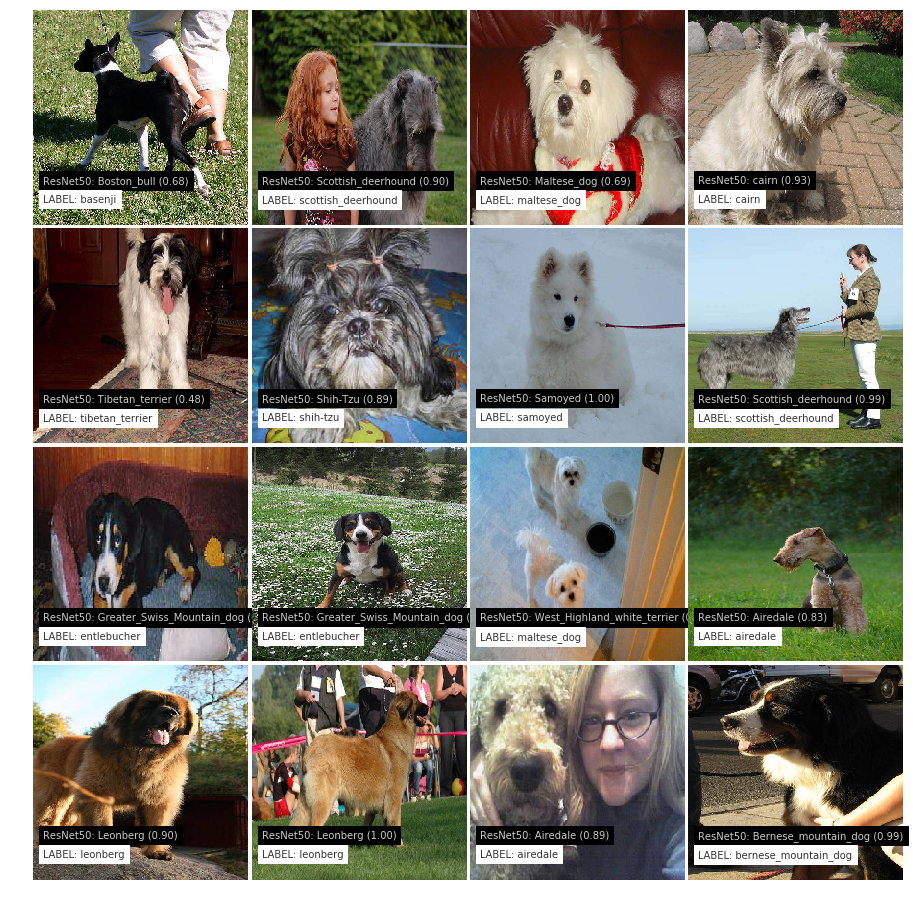

In [9]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[:119, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

Preprocessing and prediction seems to be working. 75% accuracy on these 16 images.

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_108[0][0]             
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_109[0][0]             
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_39 (Add)                    (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_117[0][0]             
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 28, 28, 512)  0           add_39[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_120[0][0]             
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_131 (Activation)     (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_131[0][0]             
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_43 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_129[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_142 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_142[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_143 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_143[0][0]             
__________

# Extract VGG16 bottleneck features

In [11]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:14, 120.54it/s]


Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [13]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 8ms/step
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


# LogReg on VGG bottleneck features

In [22]:
q = (ytr * range(NUM_CLASSES)).sum(axis=1)
q[0:10]

array([ 8.,  0.,  1., 13., 11.,  5.,  9.,  0.,  3.,  3.])

In [23]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [24]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.35235634204220057
Validation VGG Accuracy 0.9184782608695652


Not bad, 90% accuracy for the top 16 classes. The multiclass classification with 120 classes is more difficult so these LogLoss/Accuracy scores does not translate to LB.

# Extract Xception bottleneck features

In [25]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 192.25it/s]


Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [26]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 15ms/step
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Xception bottleneck features


In [27]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.06823547293187673
Validation Xception Accuracy 0.9809782608695652


![](https://pics.me.me/such-wow-much-awesome-many-cool-bestest-thug-life-19337110.png)

Much better! 98% accuracy 0.07 LogLoss.

# Extract Inception bottleneck features

In [28]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 10ms/step
InceptionV3 train bottleneck features shape: (1409, 2048) size: 2,885,632
InceptionV3 valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Inception bottleneck features

In [29]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [30]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 0.08065565345863941
Validation Inception Accuracy 0.967391304347826


# LogReg on all bottleneck features

In [31]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Full train bottleneck features shape: (1409, 4096) size: 5,771,264
Full valid bottleneck features shape: (368, 4096) size: 1,507,328
Validation Xception + Inception LogLoss 0.07073327161485053
Validation Xception + Inception Accuracy 0.9755434782608695


Training this model on the full dataset would give 0.3 LogLoss on LB.

# Check errors
We still have a few misclassification errors.

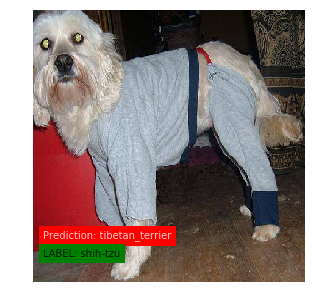

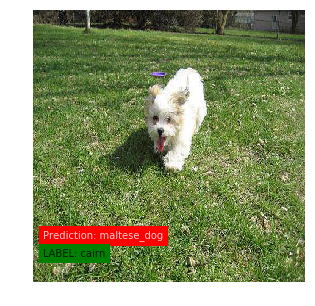

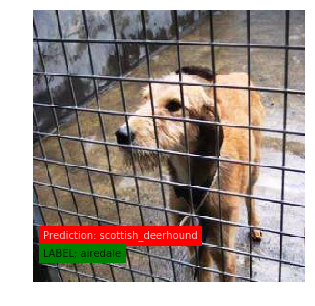

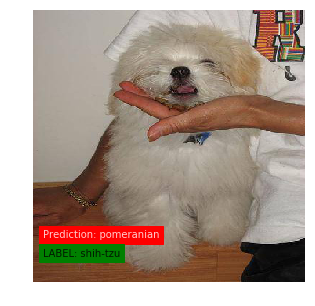

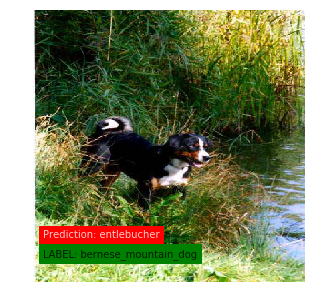

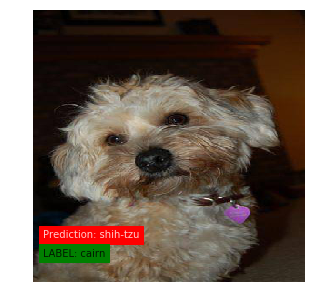

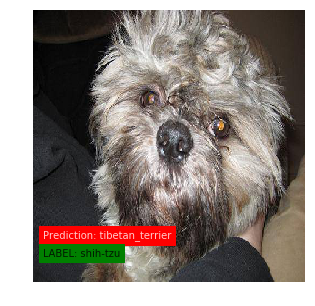

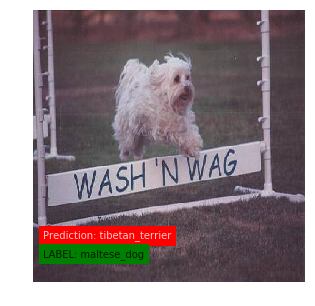

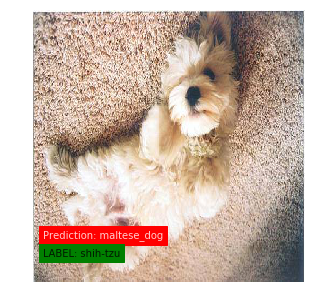

In [32]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()                                                    

In [ ]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')